In [4]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [5]:
import numpy as np
import lmfit as lmf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm 
import os
%matplotlib inline

os.chdir('C:\\Users\\Eric\\Desktop\\Lab_Work\\impedance\\PbS-TBAI\\ZnO_2\\dev2\\data')

# os.listdir()
tmax = 16
T = np.linspace(180,180+(10*tmax),tmax,endpoint=False)
devNum = 2
voltage1 = 400
voltage2 = 500

nPoints = 201
master400mv = np.zeros((tmax,nPoints,5))
master500mv = np.zeros((tmax,nPoints,5))

is400 = np.zeros((tmax,nPoints,4))
is500 = np.zeros((tmax,nPoints,4))

# the tmp data has the following format:
#      index 0 is frequency in rad/s
#      index 1 is capacitance, C
#      index 2 is susceptance, B
#      index 3 is dissipation, D
#      index 4 is conductance, G

# we create arrays to hold the impedance data (isv1/isv2) with the following format:
#      index 0 is Re(Z) in kOhm*cm^2
#      index 1 is Im(Z) in kOhm*cm^2
#      index 2 is |Z| in kOhm*cm^2
#      index 3 is phase angle \phi in degrees

for t in range(0,tmax):
    file1 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage1) + 'mV_All_Modified.txt'     
    tmp1 = np.genfromtxt(file1)
    master400mv[t,:,0] = tmp1[1:,0]
    master400mv[t,:,1] = savitzky_golay(tmp1[1:,1],51,5)
    master400mv[t,:,2] = savitzky_golay(tmp1[1:,2],51,5)
    master400mv[t,:,3] = savitzky_golay(tmp1[1:,3],51,5)
    master400mv[t,:,4] = savitzky_golay(tmp1[1:,4],51,5)

    is400[t,:,0] = ((master400mv[t,:,4]/((master400mv[t,:,4]**2) + (master400mv[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,1] = ((-master400mv[t,:,2]/((master400mv[t,:,4]**2) + (master400mv[t,:,2]**2)))*4e-2)/1e3
    is400[t,:,2] = np.sqrt((is400[t,:,0]**2) + (is400[t,:,1]**2))
    is400[t,:,3] = -np.arctan(is400[t,:,1]/is400[t,:,0])*(180/np.pi)
                           
        
    file2 = 'dev' + str(devNum) + '_T' + np.array2string(T[t].astype(int)) +'K_Vbias' + str(voltage2) + 'mV_All_Modified.txt'     
    tmp2 = np.genfromtxt(file2)
    master500mv[t,:,0] = tmp2[1:,0]    
    master500mv[t,:,1] = savitzky_golay(tmp2[1:,1],51,5)
    master500mv[t,:,2] = savitzky_golay(tmp2[1:,2],51,5)
    master500mv[t,:,3] = savitzky_golay(tmp2[1:,3],51,5)
    master500mv[t,:,4] = savitzky_golay(tmp2[1:,4],51,5)

    is500[t,:,0] = ((master500mv[t,:,4]/((master500mv[t,:,4]**2) + (master500mv[t,:,2]**2)))*4e-2)/1e3
    is500[t,:,1] = ((-master500mv[t,:,2]/((master500mv[t,:,4]**2) + (master500mv[t,:,2]**2)))*4e-2)/1e3
    is500[t,:,2] = np.sqrt((is500[t,:,0]**2) + (is500[t,:,1]**2))
    is500[t,:,3] = -np.arctan(is500[t,:,1]/is500[t,:,0])*(180/np.pi)
    


# define some simple functions to make the analysis code a bit more concise
def Zr400(T):
    return is400[T,:,0]

def Zr500(T):
    return is500[T,:,0]

def Zi400(T):
    return is400[T,:,1]

def Zi500(T):
    return is500[T,:,1]

def Zmag400(T):
    return is400[T,:,2]

def Zmag500(T):
    return is500[T,:,2]

def phi400(T):
    return is400[T,:,3]

def phi500(T):
    return is500[T,:,3]

def w(T):
    return master400mv[t,:,0]

# input useful constants
kB = 8.617e-5

# make colormap
colSet = (cm.plasma(np.linspace(0,1,tmax)))

# indicate the figures directory
figDir = "C:\\Users\\Eric\\Desktop\\Lab_Work\\impedance\\PbS-TBAI\\ZnO_2\\dev2\\analysis"

# indicate offset, if any. tmin = 0 indicates no offset. otherwise, input another minumum temp to start analysis
tmin = 1



Let's first look at the 400mV data and see what the deal is. Look at the Nyqsuit, Bode, and Re(Z) and Im(Z) plots.

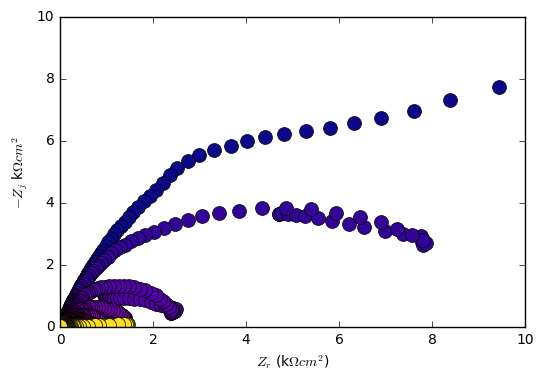

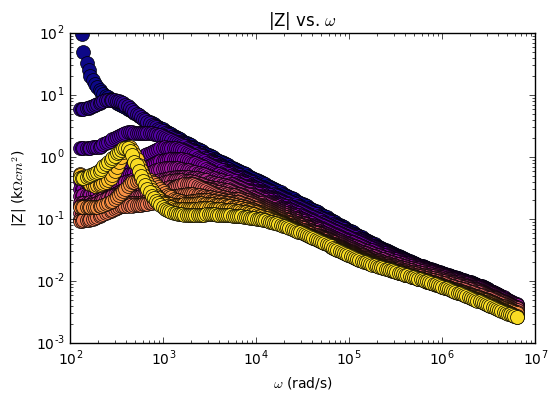

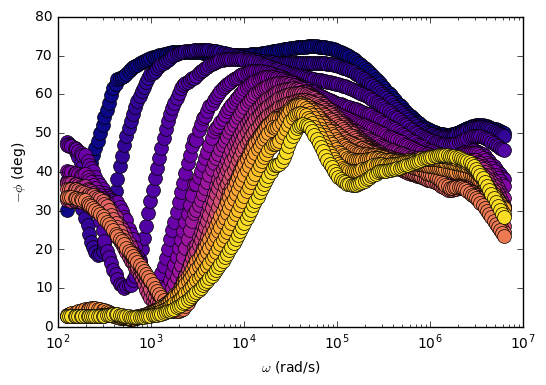

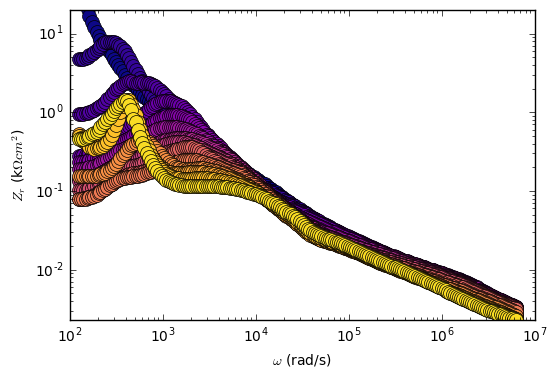

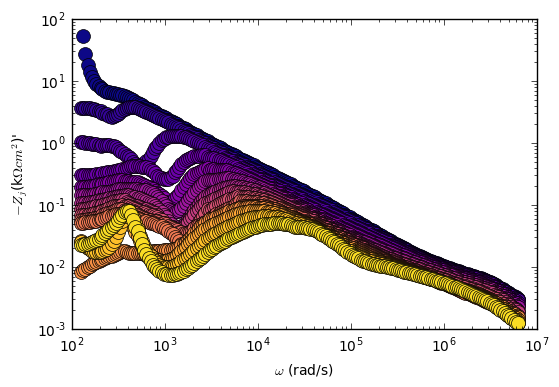

In [6]:
# Nyquist plots
fig,ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(Zr400(t),-Zi400(t),'o',c = c, markersize = 10)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{j}$ k$\Omega cm^{2}$")
ax.axis([0,10, 0,10])
# figName = '\\nyquist_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),Zmag400(t),'o',c = c, markersize = 10) 
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),phi400(t),'o',c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),Zr400(t),'o', c = c, markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Re(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([0,2e1]);
# figName = '\\reZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Im(Z) vs. \omega
fig, ax = plt.subplots(1,1)
for t,c in zip(range(tmin,tmax),colSet):
    ax.plot(w(t),abs(-Zi400(t)),'o', c = c, markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
ax.set_ylim([1e-3,1e2]);
# figName = '\\imZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

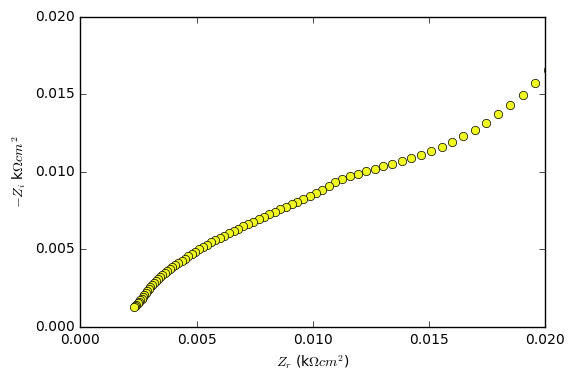

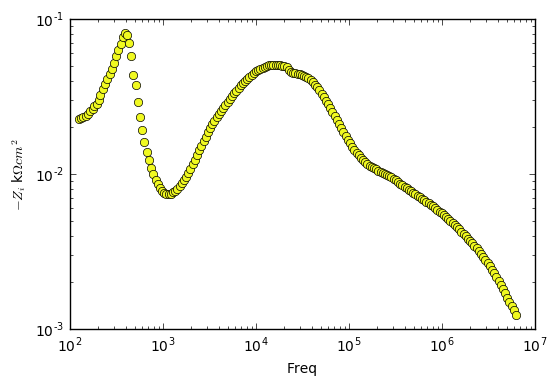

In [127]:
# inspect the plots by temperature to see where we should cut the data off 

tstar = 15

# Nyquist plots
fig,ax = plt.subplots(1,1)
# for t,c in zip(range(11,tmax),colSet):
ax.plot(Zr400(tstar),-Zi400(tstar),'o',color = tuple(colSet[tstar]))
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,0.02, 0,0.02])
# plt.savefig('nyquist_all_zoom.png')


fig,ax = plt.subplots(1,1)
# for t,c in zip(range(11,tmax),colSet):
ax.plot(w(tstar),abs(-Zi400(tstar)),'o', color = tuple(colSet[tstar]))
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 
# ax.axis([0,5, 0,1])
# plt.savefig('nyquist_all_zoom.png')

Ok. There is a lot here I don't understand. For instance, we appear to have 2 different relaxation processe with 2 different time constants for many of the temperatures--1 at low $\omega$ and 1 at high $\omega$. We even have 1 at very high $\omega$

The only thing to do is to keep track of both of them. In order to make the comparison to the $CdCl_{2}$ data, my guess is that we want to fit the high $\omega$ arc (not the very high $\omega$ behavior). However, it's probably best to fit both--it's marginally more work, and may prove to be interesting. 

So let's create 2 bounds arrays and use them both in the fit. 

We will fit the high $\omega$ arc from index 2 - index 15. 

We will fit the very high $\omega$ arc from index 13 - index 15. 

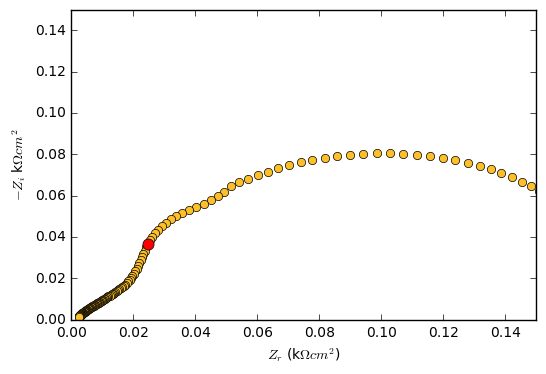

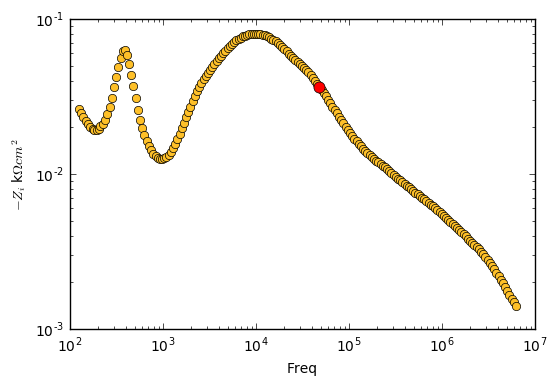

In [8]:
# clumsy way of ID-ing physically reasonable range of fit

bounds1 = np.zeros((16-2)+1)
bounds2 = np.zeros((16-13)+1)


Tt = 13
iguess = 110


fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt),-Zi400(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(Zr400(Tt)[iguess],-Zi400(Tt)[iguess],'ro', markersize = 8)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.15, 0,.15])

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[iguess],-Zi400(Tt)[iguess],'ro', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

bounds1[0] = 19
bounds1[1] = 27
bounds1[2] = 39
bounds1[3] = 42
bounds1[4] = 42
bounds1[5] = 43
bounds1[6] = 44
bounds1[7] = 47
bounds1[8] = 73
bounds1[9] = 67
bounds1[10] = 58
bounds1[11] = 58
bounds1[12] = 58
bounds1[13] = 58

# bounds2[1] = 
# bounds2[2] = 
# bounds2[3] = 
# bounds2[4] = 


Interestingly enough, the *highest* $\omega$ shoulder looks like it comes from the Warburg-y part at low F (diffusion part). That's clearly not an RC arc, and we shouldn't treat it as such.

The other arc looks like it comes out of a little shoulder. For instance, at $T = 310$ K, the shoulder appears at $\omega$ index 110. However, looking at $Im(Z)$ vs. $\omega$ in that neighborhood, the peak doesn't appear well defined. 

So for now let's just fit 1 CPE to this data and see what shakes out. We can always add in features later. 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


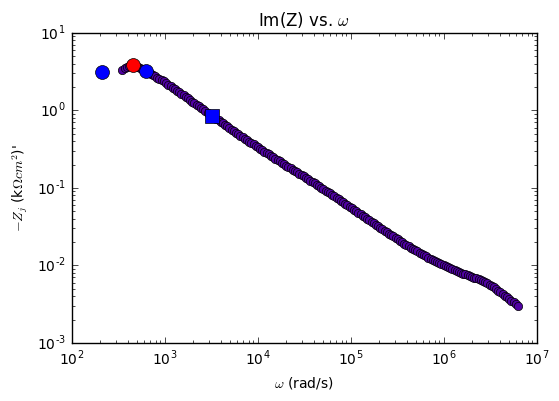

In [9]:
# Extract \alpha from the slope of the Im(z) vs. \omega.

# hardcode the offset above
offSet = 2

# First obtain the bounds by inspection
fig, ax = plt.subplots(1,1)
ax.plot(w(offSet)[bounds1[0]:],abs(-Zi400(offSet)[bounds1[0]:]),'o', color = tuple(colSet[offSet]))
ax.plot(w(offSet)[24],abs(-Zi400(offSet)[24]),'ro',markersize = 10)
ax.plot(w(offSet)[20 + 10],abs(-Zi400(offSet)[20 + 10]),'bo',markersize = 10)
ax.plot(w(offSet)[20 + 40],abs(-Zi400(offSet)[20 + 40]),'bs',markersize = 10)
ax.plot(w(offSet)[20 - 10],abs(-Zi400(offSet)[20 - 10]),'bo',markersize = 10)
# ax.plot(w(5)[20 + 30],abs(-Zi(5)[20 + 30]),'bs',markersize = 10)
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-Z_{j}$ (k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("Im(Z) vs. $\omega$")
#ax.set_xlim([0,1]);
# ax.set_ylim([0,1]);
# plt.savefig('imZlogLTslope.png')

p1Guess = 24
bAlpha1 = np.array([30, 50])


We're going to take a detour here for a bit to see if we can use the Model class in lmfit to fit the data. 

First, we're going to have to define an arc model. Then, we have to create a composite model with multiple arcs, a series resistance, and maybe even a Warburg part. 

So let's pick out a curve on which to run this data. My guess is that we want to use the high temperature data.

[0, 0.02, 0, 0.02]

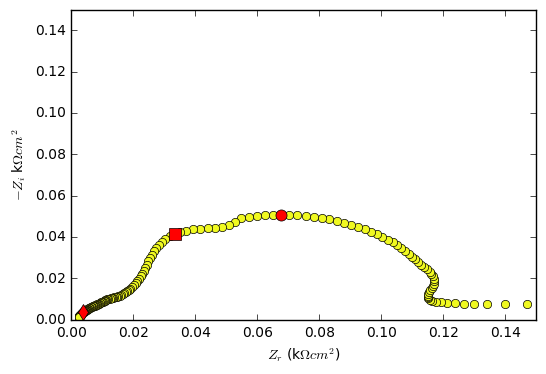

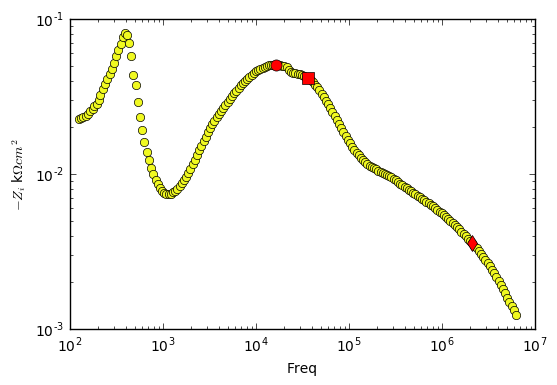

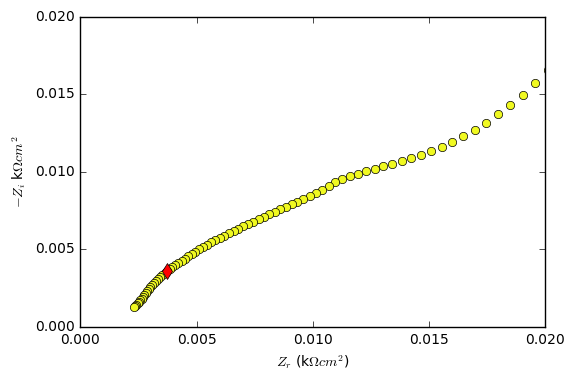

In [10]:
Tt = 15
iguess1 = 90
iguess2 = 105
iguess3 = 180

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt),-Zi400(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(Zr400(Tt)[iguess1],-Zi400(Tt)[iguess1],'ro', markersize = 8)
ax.plot(Zr400(Tt)[iguess2],-Zi400(Tt)[iguess2],'rs', markersize = 8)
ax.plot(Zr400(Tt)[iguess3],-Zi400(Tt)[iguess3],'rd', markersize = 8)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.15, 0,.15])

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[iguess1],-Zi400(Tt)[iguess1],'ro', markersize = 8)
ax.plot(w(Tt)[iguess2],-Zi400(Tt)[iguess2],'rs', markersize = 8)
ax.plot(w(Tt)[iguess3],-Zi400(Tt)[iguess3],'rd', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt),-Zi400(Tt),'o', color = tuple(colSet[Tt]))
ax.plot(Zr400(Tt)[iguess1],-Zi400(Tt)[iguess1],'ro', markersize = 8)
ax.plot(Zr400(Tt)[iguess2],-Zi400(Tt)[iguess2],'rs', markersize = 8)
ax.plot(Zr400(Tt)[iguess3],-Zi400(Tt)[iguess3],'rd', markersize = 8)
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.02, 0,.02])

So it *does* appear that we have 2 RC arcs and a high frequency diffusion impedance. Let's define circuit elements for the RC arcs and the diffusion element. Let's also define an element for the series resistance Rs.

In [11]:
# define a model class for a single RC arc to use in the composite model
def arc(w,Rct,Q,alpha):
    return Rct/(1+((1j*w)**alpha)*Q*Rct)

# define a model forWarburg diffusion
def warburg(w,Rd,td):
    return Rd*(np.tanh(np.sqrt(1j*w*td))/(np.sqrt(1j*w*td)))

# define a generaliezd blocking CPE impedance
def cpe(w,Q,alpha):
    return 1/(((1j*w)**alpha)*Q)

from lmfit.models import ConstantModel
from lmfit import Model
 
# define a function that picks out the index of a value read off the graph. This should make it easier to bound the fits    
def idx_of(arrval, value):
    if value < min(arrval):
        return 0
    return max(np.where(arrval <= value)[0])






Now that we have all the neccesary functions, let's try building the composite model and adding our guesses.

[60 75]
[115 130]


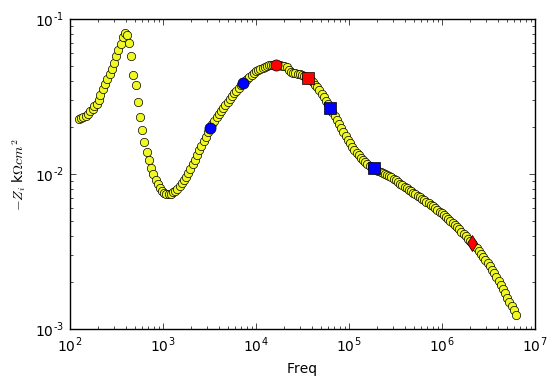

In [12]:
# extract guesses for Q1,Q2, /alpha1, and /apha 2

fig,ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))

ax.plot(w(Tt)[iguess1],-Zi400(Tt)[iguess1],'ro', markersize = 8)
ax.plot(w(Tt)[iguess1-15],-Zi400(Tt)[iguess1-15],'bo', markersize = 8)
ax.plot(w(Tt)[iguess1-15-15],-Zi400(Tt)[iguess1-15-15],'bo', markersize = 8)

ax.plot(w(Tt)[iguess2],-Zi400(Tt)[iguess2],'rs', markersize = 8)
ax.plot(w(Tt)[iguess2+10],-Zi400(Tt)[iguess2+10],'bs', markersize = 8)
ax.plot(w(Tt)[iguess2+10+20],-Zi400(Tt)[iguess2+10+20],'bs', markersize = 8)

ax.plot(w(Tt)[iguess3],-Zi400(Tt)[iguess3],'rd', markersize = 8)
ax.set_xlabel("Freq")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.set_xscale("log") 
ax.set_yscale("log") 

bAlpha1 = np.sort(np.array([iguess1-15,iguess1-30]))
bAlpha2 = np.array ([iguess2+10, iguess2+25])

print(bAlpha1)
print(bAlpha2)



0.835566533406 -10.6575864278
-0.995545105096 7.35645540714


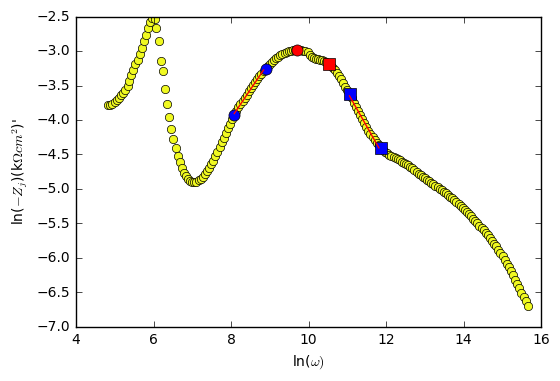

In [13]:
# Fit the lines and plot to make sure everything is good
x1 = np.vstack( [np.log(w(Tt)[bAlpha1[0]:bAlpha1[1]]), np.ones(len(w(Tt)[bAlpha1[0]:bAlpha1[1]]))]).T
y1 = np.log(abs(Zi400(Tt)[bAlpha1[0]:bAlpha1[1]]))
m1,c1 = np.linalg.lstsq(x1,y1)[0]
print(m1,c1)

x2 = np.vstack( [np.log(w(Tt)[bAlpha2[0]:bAlpha2[1]]), np.ones(len(w(Tt)[bAlpha2[0]:bAlpha2[1]]))]).T
y2 = np.log(abs(Zi400(Tt)[bAlpha2[0]:bAlpha2[1]]))
m2,c2 = np.linalg.lstsq(x2,y2)[0]
print(m2,c2)

fig, ax = plt.subplots(1,1)
ax.plot(np.log(w(Tt)),np.log(abs(-Zi400(Tt))),'o', color = tuple(colSet[Tt]))
ax.plot(np.log(w(Tt)[iguess1]),np.log(abs(-Zi400(Tt)[iguess1])),'ro',markersize = 8)
ax.plot(np.log(w(Tt)[iguess2]),np.log(abs(-Zi400(Tt)[iguess2])),'rs',markersize = 8)

ax.plot(np.log(w(Tt)[bAlpha1[0]]),np.log(abs(-Zi400(Tt)[bAlpha1[0]])),'bo',markersize = 8)
ax.plot(np.log(w(Tt)[bAlpha1[1]]),np.log(abs(-Zi400(Tt)[bAlpha1[1]])),'bo',markersize = 8)
ax.plot(np.log(w(Tt)[bAlpha1[0]:bAlpha1[1]]), m1*np.log(w(Tt)[bAlpha1[0]:bAlpha1[1]]) + c1, 'r')

ax.plot(np.log(w(Tt)[bAlpha2[0]]),np.log(abs(-Zi400(Tt)[bAlpha2[0]])),'bs',markersize = 8)
ax.plot(np.log(w(Tt)[bAlpha2[1]]),np.log(abs(-Zi400(Tt)[bAlpha2[1]])),'bs',markersize = 8)
ax.plot(np.log(w(Tt)[bAlpha2[0]:bAlpha2[1]]), m2*np.log(w(Tt)[bAlpha2[0]:bAlpha2[1]]) + c2, 'r')

ax.set_xlabel("ln($\omega)$")
ax.set_ylabel("ln($-Z_{j}$)(k$\Omega cm^{2}$)'")

alphaG1 = abs(m1)
alphaG2 = abs(m2)

So our guesses are:

1) $\alpha_{1} \approx 0.84$ 

2) $\alpha_{2} \approx 1$ 

Interesting enough. What about the Q values?

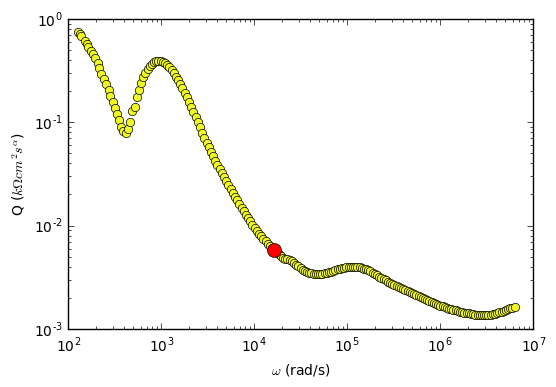

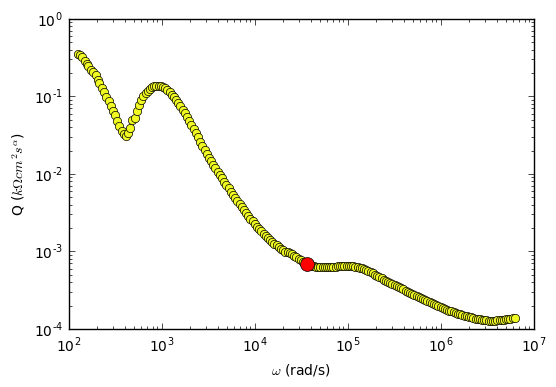

In [14]:
# Estimate the Q value based on the alpha value

Qarray1 = np.sin((alphaG1*np.pi)/2)*(-1/(Zi400(Tt)*w(Tt)**(alphaG1)))
Qarray2 = np.sin((alphaG2*np.pi)/2)*(-1/(Zi400(Tt)*w(Tt)**(alphaG2)))

fig, ax = plt.subplots(1,1)
ax.plot(w(offSet),Qarray1,'o', color= tuple(colSet[Tt]))
ax.plot(w(offSet)[iguess1],Qarray1[iguess1],'ro', markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("Q ($k \Omega cm^{2} s^{\\alpha}$)")
ax.set_xscale("log") 
ax.set_yscale("log")

fig, ax = plt.subplots(1,1)
ax.plot(w(offSet),Qarray2,'o', color= tuple(colSet[Tt]))
ax.plot(w(offSet)[iguess2],Qarray2[iguess2],'ro', markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("Q ($k \Omega cm^{2} s^{\\alpha}$)")
ax.set_xscale("log") 
ax.set_yscale("log")

In [15]:
wEff = np.argmax(w(Tt) > 2e6)
Qguess1 = Qarray1[wEff]
Qguess2 = Qarray2[wEff]
print(wEff,Qguess1,Qguess2)

179 0.00141298358895 0.000143267085146


Our guesses are:

1) $Q_{1} = 1.41 \times 10^{-3} k\Omega^{-1} cm^{-2} s^{\alpha_{1}}$

2) $Q_{2} = 1.43 \times 10^{-4} k\Omega^{-1} cm^{-2} s^{\alpha_{2}}$

Now build the composite model.

[[Model]]
    ((Model(arc, prefix='a1_') + Model(arc, prefix='a2_')) + Model(warburg))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 124
    # data points      = 286
    # variables        = 8
    chi-square         = 4.4782e-04
    reduced chi-square = 1.6109e-06
    Akaike info crit   = -3806.99397
    Bayesian info crit = -3777.74604
[[Variables]]
    a1_Rct:    0.00173766 +/- 0.00501843 (288.80%) (init = 0.3)
    a1_alpha:  0.02497588 +/- 146843.132 (587939792.34%) (init = 0.8355665)
    a1_Q:      2.3328e-07 +/- 42.2476958 (18110319181.65%) (init = 0.001)
    a2_Rct:    0.10569182 +/- 0.00128078 (1.21%) (init = 0.3)
    a2_alpha:  0.97804394 +/- 0.00598725 (0.61%) (init = 0.9955451)
    a2_Q:      7.1282e-04 +/- 3.4443e-05 (4.83%) (init = 0.0001432671)
    Rd:        0.01296515 +/- 9.6914e-04 (7.47%) (init = 0.3)
    td:        5.1098e-06 +/- 4.0801e-07 (7.98%) (init = 1e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(a2_alpha, a2_Q

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:25: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[0, 0.12, 0, 0.12]

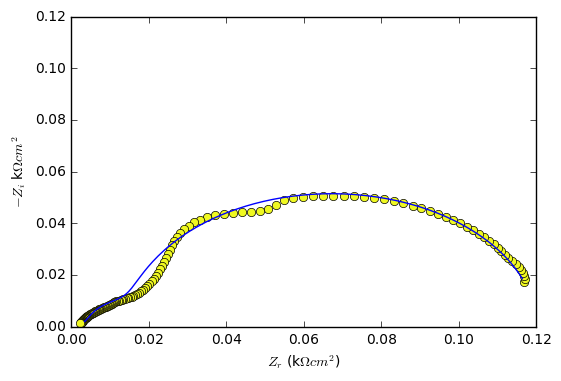

In [170]:
# build composite model

# define model objects based on impedance functions above, with prefixes where appropriate
arc1 = Model(arc, prefix = 'a1_')
arc2 = Model(arc,prefix = 'a2_')
diffMod = Model(warburg)

# build the aggregate model
aggModel = arc1 + arc2 + diffMod 

# add parameters with guesses
params = lmf.Parameters()  
params.add('a1_Rct',value = 0.3, min = 0, max = 5)
params.add('a1_alpha',value = alphaG1, min = 0, max = 1)
params.add('a1_Q',value = Qguess1, min = 0, max = 1e-3)

params.add('a2_Rct',value = 0.3, min = 0, max = 5)
params.add('a2_alpha',value = alphaG2, min = 0, max = 1)
params.add('a2_Q',value = Qguess2, min = 0, max = 1e-3)

params.add('Rd',value = 0.3, min = 0, max = 5)
params.add('td',value = 1e-5, min = 0, max = 1e-4)

# make data complex 
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params)

print(fit_result.fit_report())

Rct1 = fit_result.params['a1_Rct'].value
alpha1 = fit_result.params['a1_alpha'].value
Q1 = fit_result.params['a1_Q'].value

Rct2 = fit_result.params['a2_Rct'].value
alpha2 = fit_result.params['a2_alpha'].value
Q2 = fit_result.params['a2_Q'].value

RdFit = fit_result.params['Rd'].value
tdFit = fit_result.params['td'].value


def aggModelRe(w,a1_Rct,a1_alpha,a1_Q,a2_Rct,a2_alpha,a2_Q,Rd,td):
    return np.real((a1_Rct/(1+((1j*w)**a1_alpha)*a1_Q*a1_Rct)) + (a2_Rct/(1+((1j*w)**a2_alpha)*a2_Q*a2_Rct)) + Rd*(np.tanh(np.sqrt(1j*w*td))/(np.sqrt(1j*w*td))))    

def aggModelIm(w,a1_Rct,a1_alpha,a1_Q,a2_Rct,a2_alpha,a2_Q,Rd,td):
    return np.imag((a1_Rct/(1+((1j*w)**a1_alpha)*a1_Q*a1_Rct)) + (a2_Rct/(1+((1j*w)**a2_alpha)*a2_Q*a2_Rct)) + Rd*(np.tanh(np.sqrt(1j*w*td))/(np.sqrt(1j*w*td))))    

# plot the data with the fit to see what happened
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))


ax.plot(aggModelRe(w(Tt)[bounds1[Tt-offSet]:],Rct1,alpha1,Q1,Rct2,alpha2,Q2,RdFit,tdFit),-aggModelIm(w(Tt)[bounds1[Tt-offSet]:],Rct1,alpha1,Q1,Rct2,alpha2,Q2,RdFit,tdFit))  

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.12, 0,.12])

In [ ]:
# build composite model

# define model objects based on impedance functions above, with prefixes where appropriate
arc1 = Model(arc, prefix = 'a1_')
arc2 = Model(arc,prefix = 'a2_')
arc3 = Model(arc,prefix = 'a3_')

# build the aggregate model
aggModel3 = arc1 + arc2 + arc3

# add parameters with guesses
params3 = lmf.Parameters()  
params3.add('a1_Rct',value = 0.3, min = 0, max = 5)
params3.add('a1_alpha',value = alphaG1, min = 0, max = 1)
params3.add('a1_Q',value = Qguess1, min = 0, max = 1e-3)

params3.add('a2_Rct',value = 0.3, min = 0, max = 5)
params3.add('a2_alpha',value = alphaG2, min = 0, max = 1)
params3.add('a2_Q',value = Qguess2, min = 0, max = 1e-3)

params3.add('a3_Rct',value = 0.3, min = 0, max = 5)
params3.add('a3_alpha',value = alphaG2, min = 0, max = 1)
params3.add('a3_Q',value = Qguess2, min = 0, max = 1e-3)

# make data complex 
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel3.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params3)

print(fit_result.fit_report())

Rct1 = fit_result.params['a1_Rct'].value
alpha1 = fit_result.params['a1_alpha'].value
Q1 = fit_result.params['a1_Q'].value

Rct2 = fit_result.params['a2_Rct'].value
alpha2 = fit_result.params['a2_alpha'].value
Q2 = fit_result.params['a2_Q'].value

Rct3 = fit_result.params['a3_Rct'].value
alpha3 = fit_result.params['a3_alpha'].value
Q3 = fit_result.params['a3_Q'].value

def aggModelRe3(w,a1_Rct,a1_alpha,a1_Q,a2_Rct,a2_alpha,a2_Q,a3_Rct,a3_alpha,a3_Q):
    return np.real((a1_Rct/(1+((1j*w)**a1_alpha)*a1_Q*a1_Rct)) + (a2_Rct/(1+((1j*w)**a2_alpha)*a2_Q*a2_Rct)) + (a3_Rct/(1+((1j*w)**a3_alpha)*a3_Q*a3_Rct)) )    

def aggModelIm3(w,a1_Rct,a1_alpha,a1_Q,a2_Rct,a2_alpha,a2_Q,a3_Rct,a3_alpha,a3_Q):
    return np.imag((a1_Rct/(1+((1j*w)**a1_alpha)*a1_Q*a1_Rct)) + (a2_Rct/(1+((1j*w)**a2_alpha)*a2_Q*a2_Rct)) + (a3_Rct/(1+((1j*w)**a3_alpha)*a3_Q*a3_Rct)) )    

# plot the data with the fit to see what happened
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))


ax.plot(aggModelRe3(w(Tt)[bounds1[Tt-offSet]:],Rct1,alpha1,Q1,Rct2,alpha2,Q2,Rct3,alpha3,Q3),-aggModelIm3(w(Tt)[bounds1[Tt-offSet]:],Rct1,alpha1,Q1,Rct2,alpha2,Q2,Rct3,alpha3,Q3))  

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.12, 0,.12])

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:33: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:61: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (((Model(warburg) + Model(arc, prefix='a1_')) + Model(arc, prefix='a2_')) + Model(arc, prefix='a3_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 118
    # data points      = 286
    # variables        = 11
    chi-square         = 0.01399135
    reduced chi-square = 5.0878e-05
    Akaike info crit   = -2816.63808
    Bayesian info crit = -2776.42217
[[Variables]]
    a1_Rct:    1.0260e-04 +/- 0.00000000 (0.00%) (init = 0.3)
    a1_alpha:  0.72433298 +/- 0.00000000 (0.00%) (init = 0.8355665)
    a1_Q:      1.4017e-04 +/- 0.00000000 (0.00%) (init = 0.001)
    a2_Rct:    7.2012e-05 +/- 0.00000000 (0.00%) (init = 0.3)
    a2_alpha:  0.70208555 +/- 0.00000000 (0.00%) (init = 0.9955451)
    a2_Q:      2.0987e-04 +/- 0.00000000 (0.00%) (init = 0.0001432671)
    a3_Rct:    1.9699e-09 +/- 0.00000000 (0.00%) (init = 0.3)
    a3_alpha:  0.90982801 +/- 0.00000000 (0.00%) (init = 0.9955451)
    a3_Q:      3.3749e-04 +/- 0.00000000 (0.00%) (init = 0.00

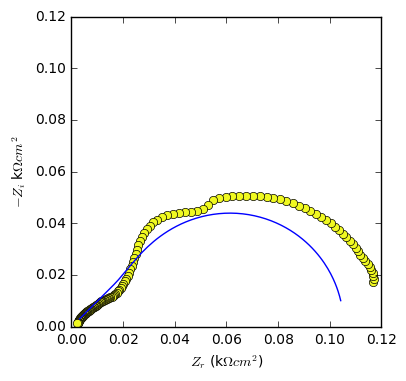

In [171]:
# build composite model

# define model objects based on impedance functions above, with prefixes where appropriate
arc1 = Model(arc, prefix = 'a1_')
arc2 = Model(arc,prefix = 'a2_')
arc3 = Model(arc,prefix = 'a3_')
diffMod = Model(warburg)

# build the aggregate model
aggModel4 = diffMod + arc1 + arc2 +arc3

# add parameters with guesses
params4 = lmf.Parameters()  
params4.add('a1_Rct',value = 0.3, min = 0, max = 5)
params4.add('a1_alpha',value = alphaG1, min = 0, max = 1)
params4.add('a1_Q',value = Qguess1, min = 0, max = 1e-3)

params4.add('a2_Rct',value = 0.3, min = 0, max = 5)
params4.add('a2_alpha',value = alphaG2, min = 0, max = 1)
params4.add('a2_Q',value = Qguess2, min = 0, max = 1e-3)

params4.add('a3_Rct',value = 0.3, min = 0, max = 5)
params4.add('a3_alpha',value = alphaG2, min = 0, max = 1)
params4.add('a3_Q',value = Qguess2, min = 0, max = 1e-3)

params4.add('Rd',value = 0.3, min = 0, max = 5)
params4.add('td',value = 1e-5, min = 0, max = 1e-4)

# make data complex 
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel4.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params4)

print(fit_result.fit_report())

Rct1 = fit_result.params['a1_Rct'].value
alpha1 = fit_result.params['a1_alpha'].value
Q1 = fit_result.params['a1_Q'].value

Rct2 = fit_result.params['a2_Rct'].value
alpha2 = fit_result.params['a2_alpha'].value
Q2 = fit_result.params['a2_Q'].value

Rct3 = fit_result.params['a3_Rct'].value
alpha3 = fit_result.params['a3_alpha'].value
Q3 = fit_result.params['a3_Q'].value

RdFit = fit_result.params['Rd'].value
tdFit = fit_result.params['td'].value


def aggModelRe4(w,a1_Rct,a1_alpha,a1_Q,a2_Rct,a2_alpha,a2_Q,a3_Rct,a3_alpha,a3_Q,Rd,td):
    return np.real((a1_Rct/(1+((1j*w)**a1_alpha)*a1_Q*a1_Rct)) + (a2_Rct/(1+((1j*w)**a2_alpha)*a2_Q*a2_Rct)) + (a3_Rct/(1+((1j*w)**a3_alpha)*a3_Q*a3_Rct)) + Rd*(np.tanh(np.sqrt(1j*w*td))/(np.sqrt(1j*w*td))))    

def aggModelIm4(w,a1_Rct,a1_alpha,a1_Q,a2_Rct,a2_alpha,a2_Q,a3_Rct,a3_alpha,a3_Q,Rd,td):
    return np.imag((a1_Rct/(1+((1j*w)**a1_alpha)*a1_Q*a1_Rct)) + (a2_Rct/(1+((1j*w)**a2_alpha)*a2_Q*a2_Rct)) + (a3_Rct/(1+((1j*w)**a3_alpha)*a3_Q*a3_Rct)) + Rd*(np.tanh(np.sqrt(1j*w*td))/(np.sqrt(1j*w*td))))    

# plot the data with the fit to see what happened
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit))

# ax.plot(aggModelRe4(w(Tt)[bounds1[Tt-offSet]:],Rct1,alpha1,Q1,Rct2,alpha2,Q2,Rct3,alpha3,Q3,RdFit,tdFit),-aggModelIm4(w(Tt)[bounds1[Tt-offSet]:],Rct1,alpha1,Q1,Rct2,alpha2,Q2,Rct3,alpha3,Q3,RdFit,tdFit))  

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')

114
101
101
101
0.0167560096944 0.0614428372308
0.00364761116672 0.000441954081963


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


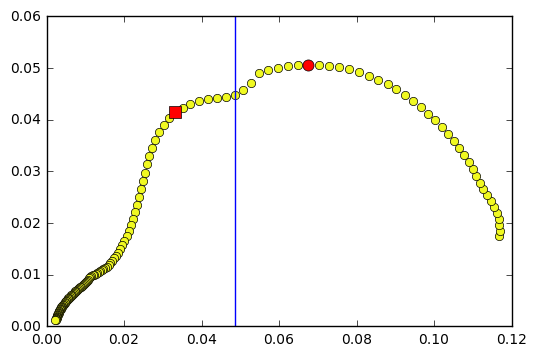

In [79]:
# try to get better estimates for these parameters

def ZrIdx(T,val):
    return max(np.where(Zr400(T) <= val))[0]


zbound1 = ZrIdx(Tt,0.025)
print(zbound1)

zbound2 = ZrIdx(Tt,0.043)
print(zbound2)

zbound3 = ZrIdx(Tt,0.05)
print(zbound2)

zbound4 = ZrIdx(Tt,0.11)
print(zbound2)

guessRct1 = Zr400(Tt)[zbound2] - Zr400(Tt)[zbound1]
guessRct2 = Zr400(Tt)[zbound4] - Zr400(Tt)[zbound3]

print(guessRct1, guessRct2)

# print(max(np.where(Zr400(Tt) <= .025))[0] )

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))

# plt.axvline(Zr400(Tt)[zbound1])
# plt.axvline(Zr400(Tt)[zbound2])

plt.axvline(Zr400(Tt)[zbound3])
# plt.axvline(Zr400(Tt)[zbound4])

ax.plot(Zr400(Tt)[iguess1],-Zi400(Tt)[iguess1],'ro', markersize = 8)
ax.plot(Zr400(Tt)[iguess2],-Zi400(Tt)[iguess2],'rs', markersize = 8)

guessQ1 = 1/(guessRct1*w(Tt)[iguess1])
guessQ2 = 1/(guessRct2*w(Tt)[iguess2])

print(guessQ1,guessQ2)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:34: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    ((Model(cpe) + Model(arc, prefix='a1_')) + Model(arc, prefix='a2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3392
    # data points      = 286
    # variables        = 8
    chi-square         = 0.00817711
    reduced chi-square = 2.9414e-05
    Akaike info crit   = -2976.24864
    Bayesian info crit = -2947.00070
[[Variables]]
    Q:         0.01005926 +/- 0.00000000 (0.00%) (init = 0.0001432671)
    alpha:     0.99999487 +/- 0.00000000 (0.00%) (init = 0.9955451)
    a1_Rct:    0.01514913 +/- 0.00000000 (0.00%) (init = 0.01675601)
    a1_alpha:  0.80574813 +/- 0.00000000 (0.00%) (init = 0.8355665)
    a1_Q:      9.8905e-04 +/- 0.00000000 (0.00%) (init = 0.001)
    a2_Rct:    0.09296356 +/- 0.00000000 (0.00%) (init = 0.06144284)
    a2_alpha:  1.00000000 +/- 0.00000000 (0.00%) (init = 0.9955451)
    a2_Q:      5.2343e-04 +/- 0.00000000 (0.00%) (init = 0.0004419541)



C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:52: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:70: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


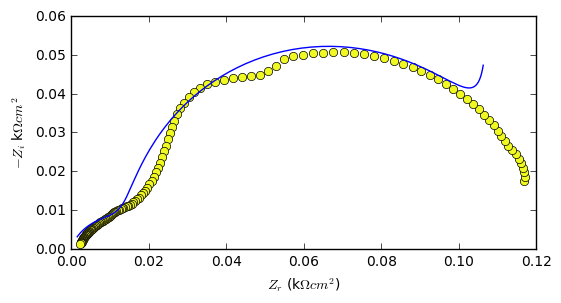

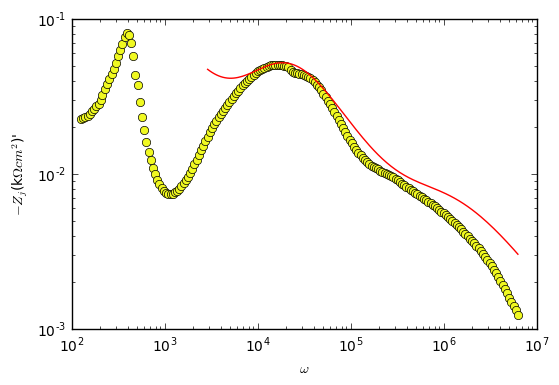

In [172]:
# now try the fit 1 last time with these 'better' parameter estimates

# build composite model

# define model objects based on impedance functions above, with prefixes where appropriate
arc1 = Model(arc, prefix = 'a1_')
arc2 = Model(arc,prefix = 'a2_')
cpe1 = Model(cpe)

# build the aggregate model
aggModel5 = cpe1 + arc1 + arc2 

# def cpe(w,Q,alpha):
#     return 1/(((1j*w)**alpha)*Q)

# add parameters with guesses
params5 = lmf.Parameters()  
params5.add('Q',value = Qguess2, min = 0, max = 5)
params5.add('alpha',value = alphaG2, min = 0, max = 1)

params5.add('a1_Rct',value = guessRct1, min = 0, max = 5)
params5.add('a1_alpha',value = alphaG1, min = 0, max = 1)
params5.add('a1_Q',value = guessQ1, min = 0, max = 1e-3)

params5.add('a2_Rct',value = guessRct2, min = 0, max = 5)
params5.add('a2_alpha',value = alphaG2, min = 0, max = 1)
params5.add('a2_Q',value = guessQ2, min = 0, max = 1e-3)


# make data complex 
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel5.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params5)

print(fit_result.fit_report())

QFit = fit_result.params['Q'].value
alphaFit = fit_result.params['alpha'].value

Rct1 = fit_result.params['a1_Rct'].value
alpha1 = fit_result.params['a1_alpha'].value
Q1 = fit_result.params['a1_Q'].value

Rct2 = fit_result.params['a2_Rct'].value
alpha2 = fit_result.params['a2_alpha'].value
Q2 = fit_result.params['a2_Q'].value


# plot the data with the fit to see what happened
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit))

# ax.plot(aggModelRe4(w(Tt)[bounds1[Tt-offSet]:],Rct1,alpha1,Q1,Rct2,alpha2,Q2,Rct3,alpha3,Q3,RdFit,tdFit),-aggModelIm4(w(Tt)[bounds1[Tt-offSet]:],Rct1,alpha1,Q1,Rct2,alpha2,Q2,Rct3,alpha3,Q3,RdFit,tdFit))  

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')

# plot the frequency domain and check what the fit is doing
imFit = np.imag(fit_result.best_fit)

# print(imFit.shape)
# print(w(Tt)[bounds1[Tt-offSet]:].shape)

fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds1[Tt-offSet]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 




C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


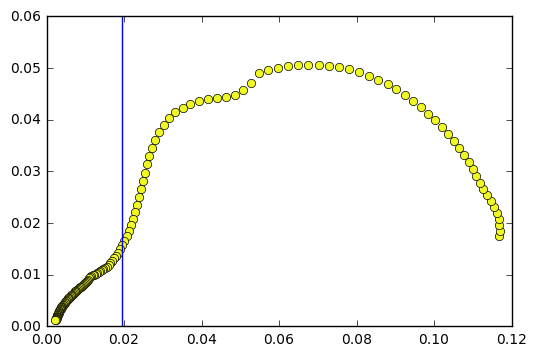

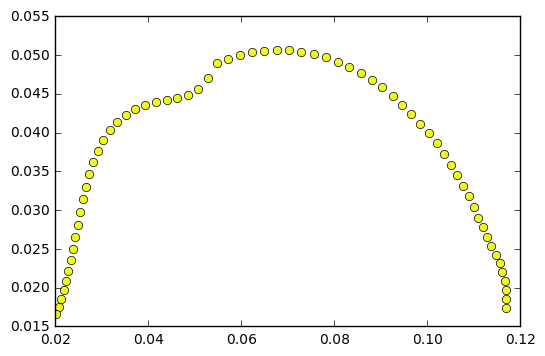

In [22]:
# try cutting out the weird diffusion part; see if we can just get 2 arcs to fit

zCut = ZrIdx(Tt,.02)

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))

plt.axvline(Zr400(Tt)[zCut])

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:zCut],-Zi400(Tt)[bounds1[Tt-offSet]:zCut],'o', color = tuple(colSet[Tt]))


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:23: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(arc, prefix='a1_') + Model(arc, prefix='a2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 283
    # data points      = 132
    # variables        = 6
    chi-square         = 1.2583e-04
    reduced chi-square = 9.9869e-07
    Akaike info crit   = -1817.96106
    Bayesian info crit = -1800.66425
[[Variables]]
    a1_Rct:    0.01551873 +/- 0.00185721 (11.97%) (init = 0.01675601)
    a1_alpha:  1.00000000 +/- 0.00372560 (0.37%) (init = 0.8355665)
    a1_Q:      3.2344e-05 +/- 5.8698e-04 (1814.83%) (init = 0.003647611)
    a2_Rct:    0.10554569 +/- 0.00207441 (1.97%) (init = 0.06144284)
    a2_alpha:  0.97580509 +/- 0.00725769 (0.74%) (init = 0.9955451)
    a2_Q:      7.3248e-04 +/- 3.3352e-05 (4.55%) (init = 0.0004419541)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1_alpha, a1_Q)     =  0.999
    C(a1_Rct, a2_Rct)     = -0.986
    C(a1_Rct, a1_Q)       =  0.968
    C(a1_Rct, a1_alpha)   =  0.961
    C(a2_alpha, a2_Q)

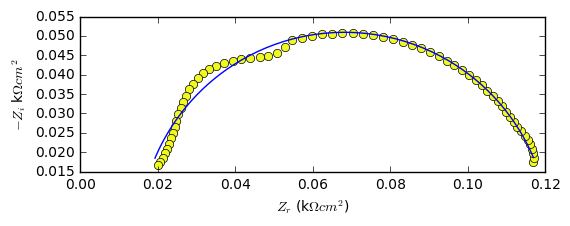

In [156]:
# now try fitting this data

# define model objects based on impedance functions above, with prefixes where appropriate
arc1 = Model(arc, prefix = 'a1_')
arc2 = Model(arc,prefix = 'a2_')

# build the aggregate model
aggModel6 =  arc1 + arc2 

# add parameters with guesses
params6 = lmf.Parameters()  

params6.add('a1_Rct',value = guessRct1, min = 0, max = 5)
params6.add('a1_alpha',value = alphaG1, min = 0, max = 1)
params6.add('a1_Q',value = guessQ1, min = 0, max = 1e-1)

params6.add('a2_Rct',value = guessRct2, min = 0, max = 5)
params6.add('a2_alpha',value = alphaG2, min = 0, max = 1)
params6.add('a2_Q',value = guessQ2, min = 0, max = 1e-3)


# make data complex 
data = Zr400(Tt)[bounds1[Tt-offSet]:zCut]+1j*Zi400(Tt)[bounds1[Tt-offSet]:zCut]

#try the fit
fit_result = aggModel6.fit(data, w = w(Tt)[bounds1[Tt-offSet]:zCut],params = params6)

print(fit_result.fit_report())

Rct1 = fit_result.params['a1_Rct'].value
alpha1 = fit_result.params['a1_alpha'].value
Q1 = fit_result.params['a1_Q'].value

Rct2 = fit_result.params['a2_Rct'].value
alpha2 = fit_result.params['a2_alpha'].value
Q2 = fit_result.params['a2_Q'].value


# plot the data with the fit to see what happened
fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:zCut],-Zi400(Tt)[bounds1[Tt-offSet]:zCut],'o', color = tuple(colSet[Tt]))

ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit))

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')




Alright so clearly there's more going on here than just 2 RC or RQ arcs. There appears to be some sort of high frequency diffusion element, with perhaps some sort of double layer capacitance as well. 

So let's take things step by step. I don't quite understand the double layer capacitance yet, though, as I noted, it could be important. Let's start with something we're a bit more familiar with: the diffusion capacitance.

What we want to do is to fit the full Randle's cicuit *in series with* another RC or RQ element. Perhaps this will solve the problem of the diffusion element for us, since it might imply a smooth transition into the high frequency diffusion impedance.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    ((Model(seriesR, prefix='Rs_') + Model(randlesZ, prefix='r_')) + Model(arc, prefix='a1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 283
    # data points      = 286
    # variables        = 9
    chi-square         = 6.2189e-04
    reduced chi-square = 2.2451e-06
    Akaike info crit   = -3711.07971
    Bayesian info crit = -3678.17578
[[Variables]]
    Rs_c:      0.00330764 +/- 0.00000000 (0.00%) (init = 0.3)
    r_Rct:     0.00106247 +/- 0.00000000 (0.00%) (init = 0.06144284)
    r_Rd:      0.11637891 +/- 0.00000000 (0.00%) (init = 0.01)
    r_td:      1.2696e-04 +/- 0.00000000 (0.00%) (init = 0.0001)
    r_Q:       2.5996e-04 +/- 0.00000000 (0.00%) (init = 0.0004419541)
    r_alpha:   0.91892537 +/- 0.00000000 (0.00%) (init = 0.9955451)
    a1_Rct:    8.8578e-09 +/- 0.00000000 (0.00%) (init = 0.01675601)
    a1_alpha:  0.21593211 +/- 0.00000000 (0.00%) (init = 0.8355665)
    a1_Q:      0.07096063 +/- 0.00000000 (0.00%) (init = 0.0036

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


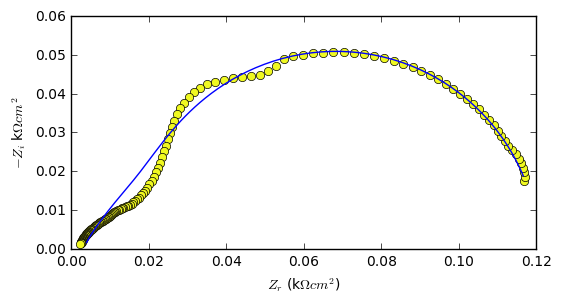

In [155]:
# define the Randles circuit
def randlesZ(w,Rct,Rd,td,Q,alpha):
    return ((Rct + Rd*(np.tanh(np.sqrt(1j*w*td))/(np.sqrt(1j*w*td)))) * 1/(((1j*w)**alpha)*Q))/ (Rct + Rd*(np.tanh(np.sqrt(1j*w*td))/(np.sqrt(1j*w*td))) + 1/(((1j*w)**alpha)*Q))     

def seriesR(w,c):
    return c

# now define a new aggregate model
randles = Model(randlesZ, prefix = 'r_')
arc1 = Model(arc,prefix = 'a1_')
# Rs = ConstantModel(independent_vars = 'w', prefix = 'Rs_')
# Rs = ConstantModel(x = ['w'], prefix = 'Rs_')
Rs = Model(seriesR,prefix = 'Rs_')



aggModel7 = Rs + randles + arc1

# add parameters with guesses
params7 = lmf.Parameters()  

params7.add('Rs_c',value =  0.3, min = 0, max = 5)

params7.add('r_Rct',value = guessRct2, min = 0, max = 5)
params7.add('r_Rd',value = .01, min = 0, max = 1)
params7.add('r_td',value = 1e-4, min = 0, max = 1e-3)
params7.add('r_Q',value = guessQ2, min = 0, max = 1e-3)
params7.add('r_alpha',value = alphaG2, min = 0, max = 1)

params7.add('a1_Rct',value = guessRct1, min = 0, max = 5)
params7.add('a1_alpha',value = alphaG1, min = 0, max = 1)
params7.add('a1_Q',value = guessQ1, min = 0, max = 1e-1)

# print(lmf.Parameters)

# make the data complex
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel7.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params7)

print(fit_result.fit_report())

fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)


fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))

ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit))

ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')


Ok so that doesn't seem to work either.

We still have options on how to do this, but it probably makes sense to first look at the frequency domain and see what the deal is.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


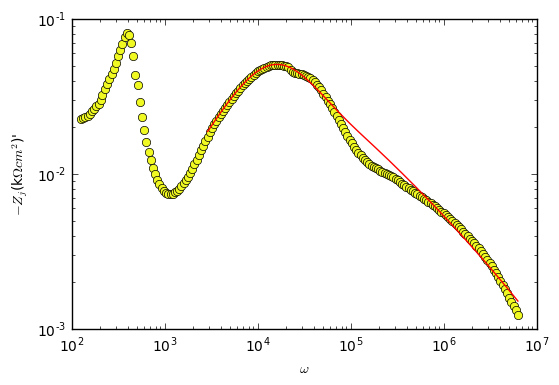

In [76]:
# plot the frequency domain and check what the fit is doing
imFit = np.imag(fit_result.best_fit)

# print(imFit.shape)
# print(w(Tt)[bounds1[Tt-offSet]:].shape)

fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds1[Tt-offSet]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 


So clearly the fit is having an issue with distinguishing between the 2 peaks since they are so close together. 

After talking with Mario, it's possible that we don't even have 2 RC elements like we thought we did; rather, perhaps we are looking at just 1 Randles circuit. For instance, see the fit to $|Z|$ vs. $\omega$ and $\phi$ vs. $\omega$. The form of $\phi$ matches that for the Randles ciruict from the grpahical methods paper from Orazem. 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0.0022957877757


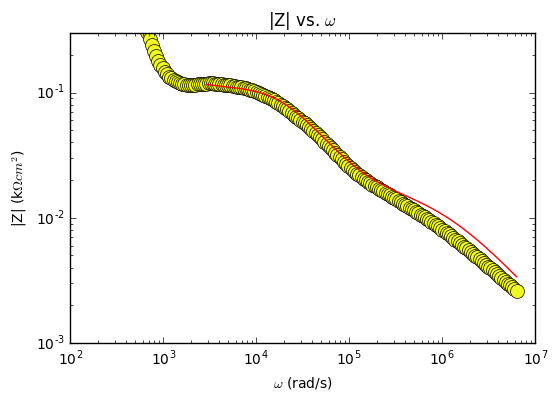

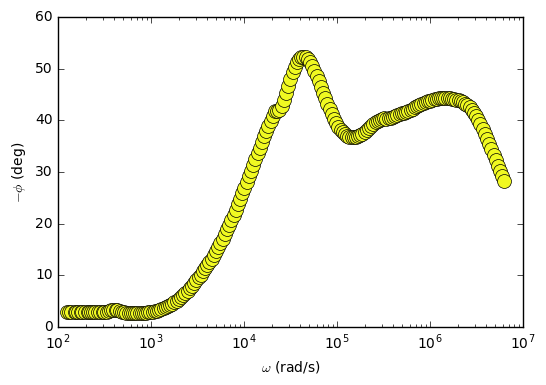

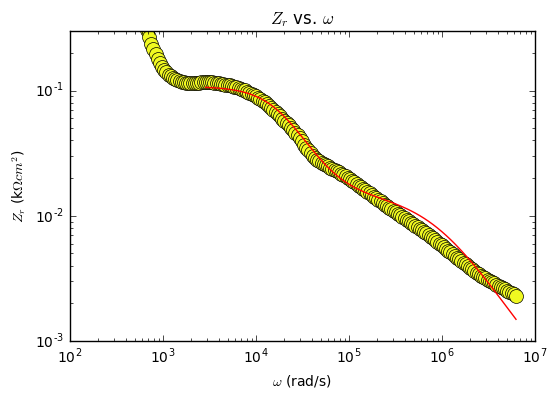

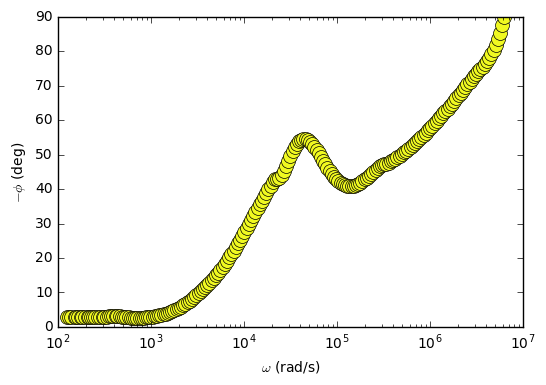

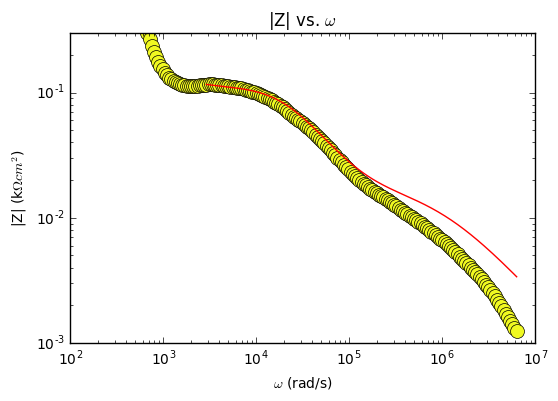

In [100]:

fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)

# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zmag400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds1[Tt-offSet]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),phi400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)

# Re(Z) vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zr400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds1[Tt-offSet]:],reFit, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("$Z_{r}$ vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'

RsEst = Zr400(Tt)[-1]

print(Zr400(Tt)[-1])


phiTest = -np.arctan(is400[t,:,1]/(is400[t,:,0]-RsEst))*(180/np.pi)

magTest = np.sqrt(((is400[t,:,0]-RsEst) **2) + (is400[t,:,1]**2))

# \phi vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),phiTest,'o',c = tuple(colSet[Tt]), markersize = 10)
# ax.set_aspect('equal')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("$-\phi$ (deg)")
ax.set_xscale("log") 
# ax.set_yscale("log") 
# ax.set_title("$\phi$ vs. $\omega$")
#ax.set_xlim([0,1]);
#ax.set_ylim([0,1]);
# figName = '\\phase_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),magTest,'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds1[Tt-offSet]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


So let's try a Randle's circuit. First, use finite diffusion. Then, use semi-infinite diffusion. See lab notebook for details on actual circuit diagram.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(seriesR, prefix='Rs_') + Model(randlesZ_finite, prefix='r_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 176
    # data points      = 286
    # variables        = 6
    chi-square         = 6.2189e-04
    reduced chi-square = 2.2210e-06
    Akaike info crit   = -3717.07971
    Bayesian info crit = -3695.14376
[[Variables]]
    Rs_c:     0.00330767 +/- 0.00154463 (46.70%) (init = 0.003)
    r_Rct:    0.00106384 +/- 0.02982056 (2803.12%) (init = 0.06144284)
    r_z0:     0.11637774 +/- 0.03140336 (26.98%) (init = 0.01)
    r_td:     1.2695e-04 +/- 6.9982e-05 (55.12%) (init = 0.0001)
    r_Q:      2.6002e-04 +/- 2.0295e-04 (78.05%) (init = 0.0004419541)
    r_alpha:  0.91892069 +/- 0.18758383 (20.41%) (init = 0.9955451)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_Rct, r_z0)    = -1.000
    C(r_Rct, r_td)    = -0.998
    C(r_z0, r_td)     =  0.996
    C(r_z0, r_alpha)  = -0.990
    C(r_Rct, r_alpha) =  0.987
    C(Rs

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


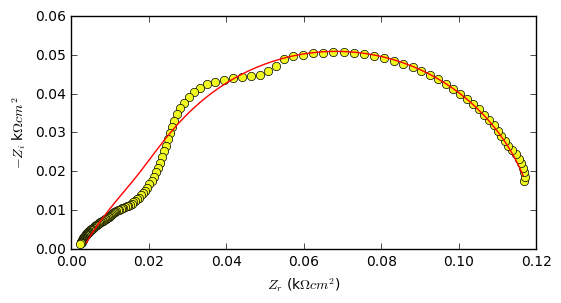

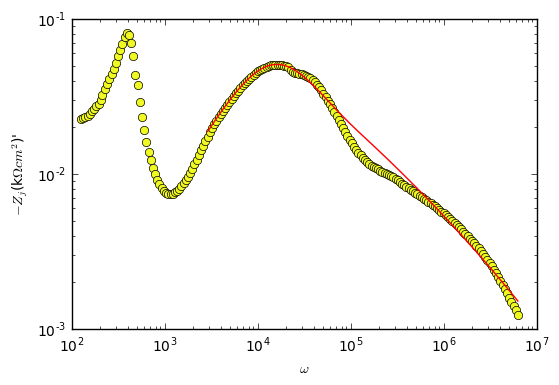

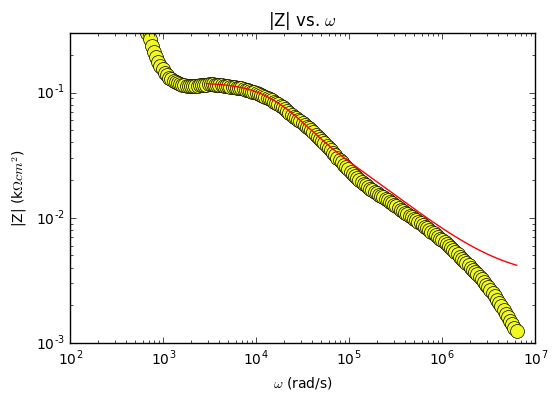

In [154]:
# define the Randles circuit
def Zd(w,z0,td):
    return z0*(np.tanh(np.sqrt(1j*w*td))/np.sqrt(1j*w*td))

def randlesZ_finite(w,Rct,Q,alpha,z0,td):
    return (Rct +  Zd(w,z0,td) ) / (1 + ((1j*w)**alpha)*Q*(Rct + Zd(w,z0,td)))

def seriesR(w,c):
    return c

# now define a new aggregate model
randles1 = Model(randlesZ_finite, prefix = 'r_')
# arc1 = Model(arc,prefix = 'a1_')
# Rs = ConstantModel(independent_vars = 'w', prefix = 'Rs_')
# Rs = ConstantModel(x = ['w'], prefix = 'Rs_')
Rs = Model(seriesR,prefix = 'Rs_')

aggModel8 = Rs + randles1 

# add parameters with guesses
params8 = lmf.Parameters()  

params8.add('Rs_c',value =  0.003, min = 0, max = 5)

params8.add('r_Rct',value = guessRct2, min = 0, max = 5)
params8.add('r_z0',value = .01, min = 0, max = 1)
params8.add('r_td',value = 1e-4, min = 0, max = 1e-3)
params8.add('r_Q',value = guessQ2, min = 0, max = 1e-3)
params8.add('r_alpha',value = alphaG2, min = 0, max = 1)


# print(lmf.Parameters)

# make the data complex
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel8.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params8)

print(fit_result.fit_report())

fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)


fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')

fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds1[Tt-offSet]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 


# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),magTest,'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds1[Tt-offSet]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


As expected, that doesn't quite fit the high $\omega$ part well and thus doesn't capture the changeover nicely. 

Let's see what we get when we try an infinite diffusion layer. 

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:35: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:38: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:48: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:57: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(seriesR, prefix='Rs_') + Model(randlesZ_inf, prefix='r_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 69
    # data points      = 286
    # variables        = 6
    chi-square         = 0.36747188
    reduced chi-square = 0.00131240
    Akaike info crit   = -1891.93069
    Bayesian info crit = -1869.99474
[[Variables]]
    Rs_c:      0.02623829 +/- 0.00452815 (17.26%) (init = 0.003)
    r_Rct:     0.10058339 +/- 0.38976722 (387.51%) (init = 0.06144284)
    r_Qd:      9.9018e-04 +/- 0.00366370 (370.00%) (init = 1e-05)
    r_alphaD:  0.98381893 +/- 0.33012664 (33.56%) (init = 0.5)
    r_Q:       8.7415e-04 +/- 0.00357409 (408.86%) (init = 0.0004419541)
    r_alpha:   0.99751683 +/- 0.37785696 (37.88%) (init = 0.9955451)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_Q, r_alpha)      = -0.999
    C(r_Qd, r_alphaD)    = -0.983
    C(r_Rct, r_Q)        =  0.968
    C(r_Rct, r_Qd)       = -0.965
    C(r_Rct, r_alpha)    =

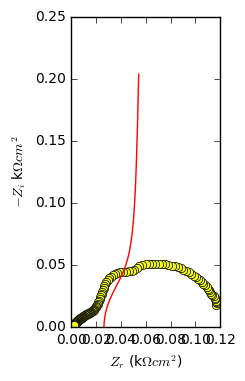

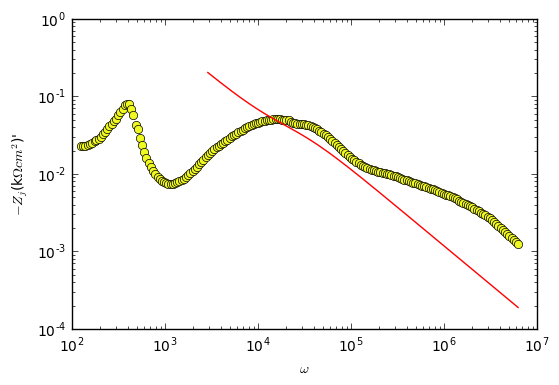

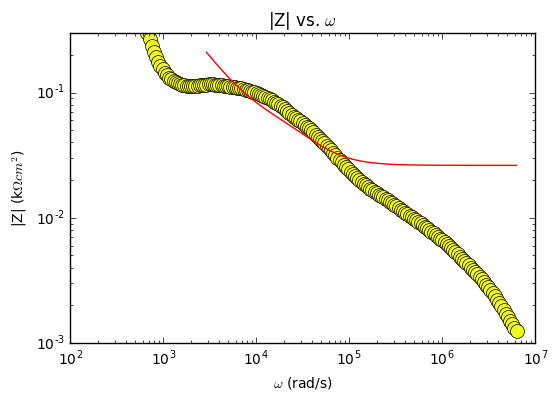

In [153]:
# define the Randles circuit
def cpeD(w,Qd,alphaD):
    return 1/(Qd*((1j*w)**alphaD))

def randlesZ_inf(w,Rct,Q,alpha,Qd,alphaD):
    return ( (Rct +  cpeD(w,Qd,alphaD))  / (1 + ((1j*w)**alpha)*Q*(Rct + cpeD(w,Qd,alphaD)) ))

def seriesR(w,c):
    return c

# now define a new aggregate model
randles2 = Model(randlesZ_inf, prefix = 'r_')
# arc1 = Model(arc,prefix = 'a1_')
# Rs = ConstantModel(independent_vars = 'w', prefix = 'Rs_')
# Rs = ConstantModel(x = ['w'], prefix = 'Rs_')
Rs = Model(seriesR,prefix = 'Rs_')

aggModel9 = Rs + randles2

# add parameters with guesses
params9 = lmf.Parameters()  

params9.add('Rs_c',value =  0.003, min = 0, max = 5)

params9.add('r_Rct',value = guessRct2, min = 0, max = 5)
params9.add('r_Qd',value = 1e-5, min = 0, max = 1e-3)
params9.add('r_alphaD',value = 0.5, min = 0, max = 1)
params9.add('r_Q',value = guessQ2, min = 0, max = 1e-3)
params9.add('r_alpha',value = alphaG2, min = 0, max = 1)


# print(lmf.Parameters)

# make the data complex
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel9.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params9)

print(fit_result.fit_report())

fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)


fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')

fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds1[Tt-offSet]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 


# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),magTest,'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds1[Tt-offSet]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


Hm. Ok, that didn't work either.

I think this doesn't work because a capacitor or CPE in series with a resistor defines a blocking electrode. Inspection of any of the impedance plots indicate that this is clearly not the situation we are dealing with.

So if I had to guess, I'd say it's 1 of 3 things: a Randles Circuit, diffusion element in series with an RC arc, or 2 RC arcs. We've tried the thing 1 of these 3 things. Let's attempt the next 2. Up first: the diffusion element in series with the RC arc.

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    ((Model(seriesR, prefix='Rs_') + Model(Zd, prefix='d_')) + Model(arc, prefix='a1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 139
    # data points      = 286
    # variables        = 6
    chi-square         = 7.6595e-04
    reduced chi-square = 2.7355e-06
    Akaike info crit   = -3657.49178
    Bayesian info crit = -3635.55583
[[Variables]]
    Rs_c:      0.00334102 +/- 4.1585e-04 (12.45%) (init = 0.003)
    d_z0:      0.07167054 +/- 0.01104828 (15.42%) (init = 0.01)
    d_td:      1.9446e-04 +/- 1.3660e-05 (7.02%) (init = 0.0001)
    a1_Rct:    0.04525050 +/- 0.01095278 (24.20%) (init = 0.06144284)
    a1_Q:      1.0000e-03 +/- 9.4535e-06 (0.95%) (init = 0.0004419541)
    a1_alpha:  1.00000000 +/- 0.02828849 (2.83%) (init = 0.8355665)
[[Correlations]] (unreported correlations are < 0.100)
    C(d_z0, a1_Rct)     = -0.999
    C(a1_Q, a1_alpha)   =  0.991
    C(a1_Rct, a1_alpha) = -0.970
    C(d_z0, a1_alpha)   =  0.965
    C(d_td, a1

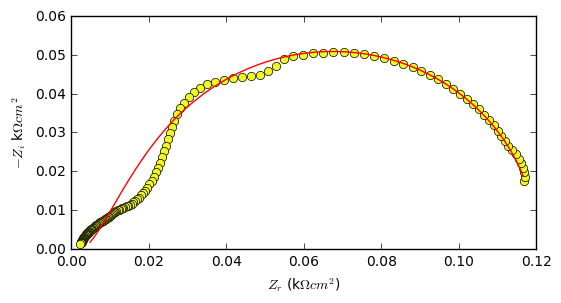

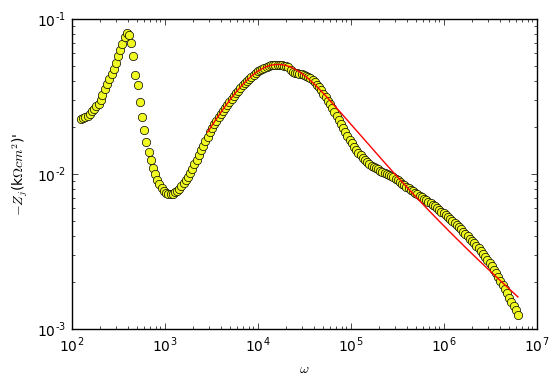

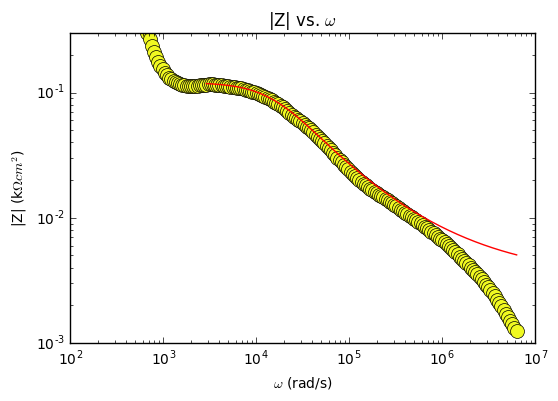

In [152]:
# define an aggregate model with a diffusion element, RC arc, and series resistance in series

finite_diff = Model(Zd,prefix = 'd_')
arc1 = Model(arc,prefix = 'a1_')
Rs = Model(seriesR,prefix = 'Rs_')

aggModel10 = Rs + finite_diff + arc1
# aggModel10 = finite_diff + arc1

# add parameters with guesses
params10 = lmf.Parameters()  

params10.add('Rs_c',value =  0.003, min = 0, max = 5)


params10.add('d_z0',value = .01, min = 0, max = 1)
params10.add('d_td',value = 1e-4, min = 0, max = 1e-3)

params10.add('a1_Rct',value = guessRct2, min = 0, max = 5)
params10.add('a1_Q',value = guessQ2, min = 0, max = 1e-3)
params10.add('a1_alpha',value = alphaG1, min = 0, max = 1)


# print(lmf.Parameters)

# make the data complex
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel10.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params10)

fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)


print(fit_result.fit_report())

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')

fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds1[Tt-offSet]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 


# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),magTest,'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds1[Tt-offSet]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


Last thing: 2 RC arcs....

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:27: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:40: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:49: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    ((Model(seriesR, prefix='Rs_') + Model(arc, prefix='a1_')) + Model(arc, prefix='a2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 286
    # variables        = 7
    chi-square         = 0.00307748
    reduced chi-square = 1.1030e-05
    Akaike info crit   = -3257.73552
    Bayesian info crit = -3232.14358
[[Variables]]
    Rs_c:      0.01268894 +/- 0.00279930 (22.06%) (init = 0.003)
    a1_Rct:    0.00769188 +/- 0.00389928 (50.69%) (init = 0.01675601)
    a1_Q:      9.5406e-04 +/- 8.9120e-04 (93.41%) (init = 0.001)
    a1_alpha:  0.71819702 +/- 0.31250609 (43.51%) (init = 0.8355665)
    a2_Rct:    0.10867300 +/- 0.00216825 (2.00%) (init = 0.06144284)
    a2_Q:      8.5097e-04 +/- 8.7691e-05 (10.30%) (init = 0.0004419541)
    a2_alpha:  0.95390755 +/- 0.01364199 (1.43%) (init = 0.9955451)
[[Correlations]] (unreported correlations are < 0.100)
    C(a1_Q, a1_alpha)     = -0.998
    C(a2_Q, a2_alpha)     = -0.984


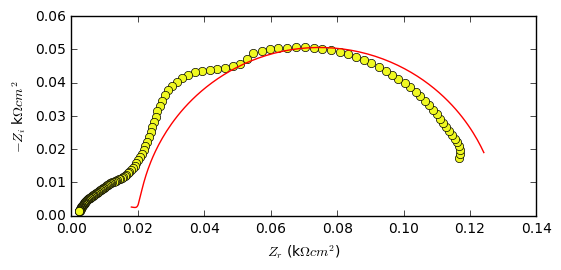

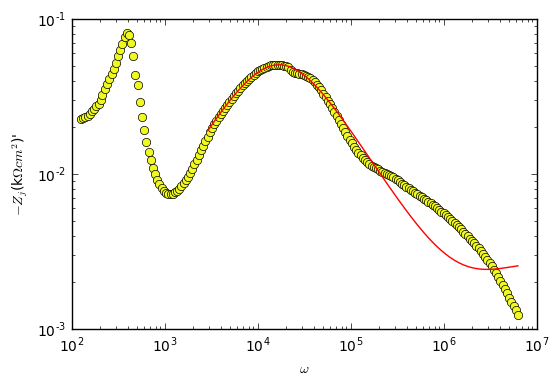

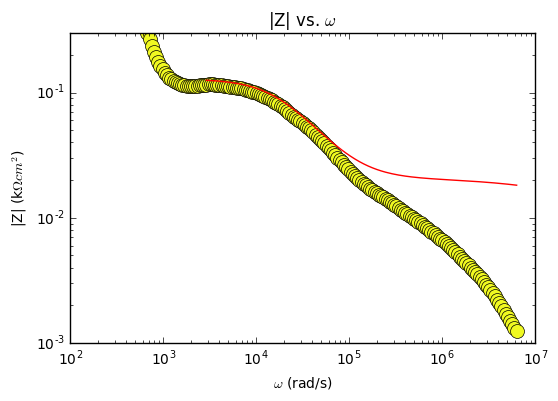

In [151]:
# define an aggregate model with a diffusion element, RC arc, and series resistance in series

arc1 = Model(arc,prefix = 'a1_')
arc2 = Model(arc,prefix = 'a2_')
Rs = Model(seriesR,prefix = 'Rs_')

# aggModel10 = Rs + finite_diff + arc1
aggModel11 = Rs + arc1 + arc2

# add parameters with guesses
params11 = lmf.Parameters()  

params11.add('Rs_c',value =  0.003, min = 0, max = 5)

params11.add('a1_Rct',value = guessRct1, min = 0, max = 5)
params11.add('a1_Q',value = guessQ1, min = 0, max = 1e-3)
params11.add('a1_alpha',value = alphaG1, min = 0, max = 1)

params11.add('a2_Rct',value = guessRct2, min = 0, max = 5)
params11.add('a2_Q',value = guessQ2, min = 0, max = 1e-3)
params11.add('a2_alpha',value = alphaG2, min = 0, max = 1)


# print(lmf.Parameters)

# make the data complex
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel11.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params11)

fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)


print(fit_result.fit_report())

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')

fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds1[Tt-offSet]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 


# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),magTest,'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds1[Tt-offSet]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


Try Randles, arc, and Rs in series again

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(seriesR, prefix='Rs_') + Model(randlesZ_finite, prefix='r_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 221
    # data points      = 286
    # variables        = 6
    chi-square         = 6.2189e-04
    reduced chi-square = 2.2210e-06
    Akaike info crit   = -3717.07971
    Bayesian info crit = -3695.14376
[[Variables]]
    Rs_c:     0.00330766 +/- 0.00154506 (46.71%) (init = 0.003)
    r_Rct:    0.00106333 +/- 0.02985910 (2808.07%) (init = 0.06144284)
    r_z0:     0.11637827 +/- 0.03143618 (27.01%) (init = 1e-05)
    r_td:     1.2695e-04 +/- 7.0056e-05 (55.18%) (init = 0.0001)
    r_Q:      2.6002e-04 +/- 2.0325e-04 (78.17%) (init = 0.0004419541)
    r_alpha:  0.91891671 +/- 0.18778513 (20.44%) (init = 0.9955451)
[[Correlations]] (unreported correlations are < 0.100)
    C(r_Rct, r_z0)    = -1.000
    C(r_Rct, r_td)    = -0.998
    C(r_z0, r_td)     =  0.996
    C(r_z0, r_alpha)  = -0.990
    C(r_Rct, r_alpha) =  0.987
    C(R

C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:55: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:64: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:74: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


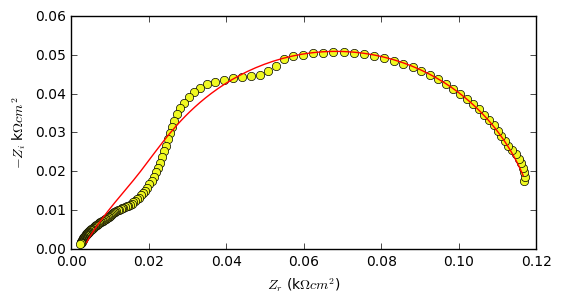

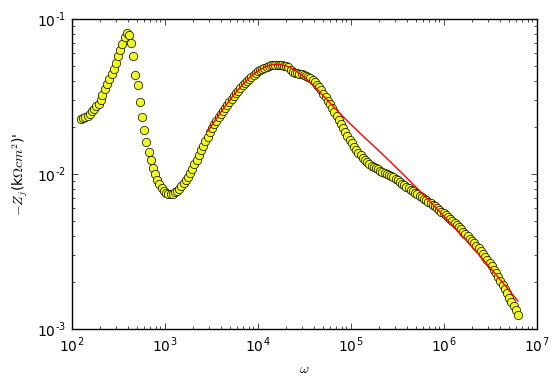

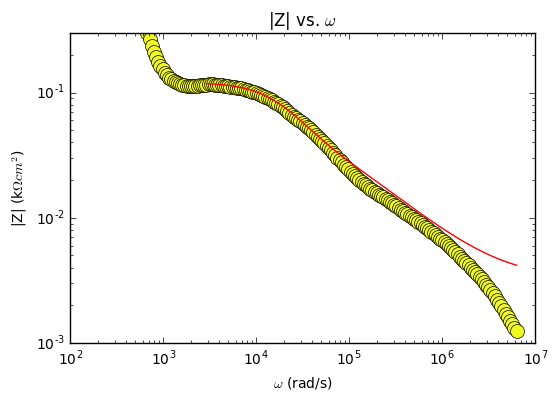

In [173]:
# define the Randles circuit
def Zd(w,z0,td):
    return z0*(np.tanh(np.sqrt(1j*w*td))/np.sqrt(1j*w*td))

def randlesZ_finite(w,Rct,Q,alpha,z0,td):
    return (Rct +  Zd(w,z0,td) ) / (1 + ((1j*w)**alpha)*Q*(Rct + Zd(w,z0,td)))

def seriesR(w,c):
    return c

# now define a new aggregate model
randles1 = Model(randlesZ_finite, prefix = 'r_')
arc1 = Model(arc,prefix = 'a1_')
# Rs = ConstantModel(independent_vars = 'w', prefix = 'Rs_')
# Rs = ConstantModel(x = ['w'], prefix = 'Rs_')
Rs = Model(seriesR,prefix = 'Rs_')

# aggModel12 = Rs + arc1 + randles1 
aggModel12 = Rs + randles1 
# aggModel12 = Rs + arc1


# add parameters with guesses
params12 = lmf.Parameters()  

params12.add('Rs_c',value =  0.003, min = 0, max = 5)

# params12.add('a1_Rct',value = guessRct1, min = 0, max = 5)
# params12.add('a1_Q',value = guessQ1, min = 0, max = 1e-3)
# params12.add('a1_alpha',value = alphaG1, min = 0, max = 1)

params12.add('r_Rct',value = guessRct2, min = 0, max = 5)
params12.add('r_z0',value = 1e-5, min = 0, max = 10)
params12.add('r_td',value = 1e-4, min = 0, max = 1e-3)
params12.add('r_Q',value = guessQ2, min = 0, max = 1e-3)
params12.add('r_alpha',value = alphaG2, min = 0, max = 1)


# print(lmf.Parameters)

# make the data complex
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel12.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params12)

print(fit_result.fit_report())

fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)


fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')

fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds1[Tt-offSet]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 


# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),magTest,'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds1[Tt-offSet]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


In [162]:
print(guessRct2)

0.0614428372308


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:42: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:45: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    ((Model(seriesR, prefix='Rs_') + Model(randlesZ_finite_anom, prefix='r_')) + Model(arc, prefix='a1_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 90
    # data points      = 286
    # variables        = 9
    chi-square         = 4.8542e-04
    reduced chi-square = 1.7524e-06
    Akaike info crit   = -3781.93684
    Bayesian info crit = -3749.03291
[[Variables]]
    Rs_c:      0.00307887 +/- 3.7957e-04 (12.33%) (init = 0.003)
    a1_Rct:    0.01157827 +/- 0.00103085 (8.90%) (init = 0.01675601)
    a1_Q:      5.0741e-04 +/- 3.6764e-04 (72.45%) (init = 0.001)
    a1_alpha:  0.91092074 +/- 0.05231041 (5.74%) (init = 0.8355665)
    r_Rct:     0.10650052 +/- 0.24858463 (233.41%) (init = 0.02)
    r_z0:      2.5865e-05 +/- 0.74578065 (2883353.84%) (init = 0.0001)
    r_td:      1.9001e-06 +/- 11.1149852 (584955382.03%) (init = 1e-05)
    r_Q:       7.7641e-04 +/- 5.8154e-05 (7.49%) (init = 0.0004419541)
    r_alpha:   0.96756265 +/- 0.00795971 

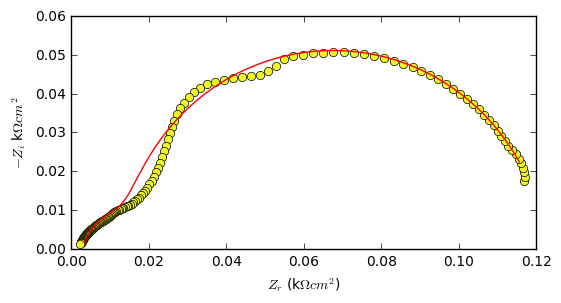

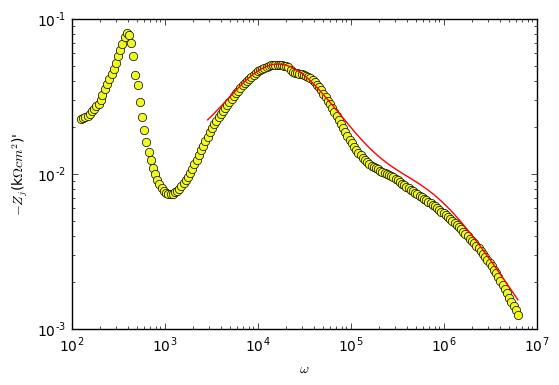

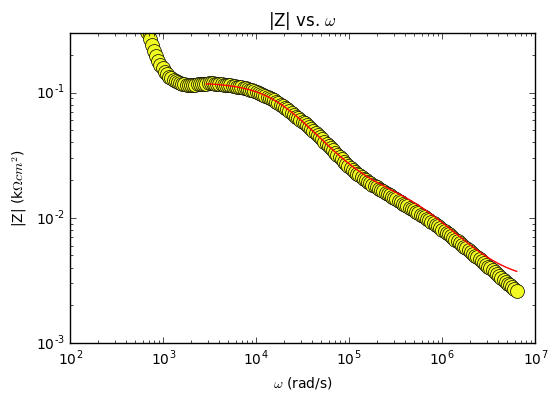

In [168]:
# define the Randles circuit
def Za(w,z0,td,alpha):
    return z0*((1/(np.tanh((1j*w*td)**(alpha/2)))) /((1j*w*td)**(alpha/2)))

def randlesZ_finite_anom(w,Rct,Q,alpha,z0,td):
    return (Rct +  Za(w,z0,td,alpha) ) / (1 + ((1j*w)**alpha)*Q*(Rct + Za(w,z0,td,alpha)))

def seriesR(w,c):
    return c

# now define a new aggregate model
randles_anom = Model(randlesZ_finite_anom, prefix = 'r_')
arc1 = Model(arc,prefix = 'a1_')
# Rs = ConstantModel(independent_vars = 'w', prefix = 'Rs_')
# Rs = ConstantModel(x = ['w'], prefix = 'Rs_')
Rs = Model(seriesR,prefix = 'Rs_')

aggModel12 = Rs + randles_anom +  arc1 
# aggModel12 = Rs + arc1


# add parameters with guesses
params12 = lmf.Parameters()  

params12.add('Rs_c',value =  0.003, min = 0, max = 5)

params12.add('a1_Rct',value = guessRct1, min = 0, max = 5)
params12.add('a1_Q',value = guessQ1, min = 0, max = 1e-3)
params12.add('a1_alpha',value = alphaG1, min = 0, max = 1)

# params12.add('r_Rct',value = guessRct2, min = 0, max = 5)
params12.add('r_Rct',value = .02, min = 0, max = 5)
params12.add('r_z0',value = .0001, min = 0, max = 1)
params12.add('r_td',value = 1e-5, min = 0, max = 1e-3)
params12.add('r_Q',value = guessQ2, min = 0, max = 1e-3)
params12.add('r_alpha',value = alphaG2, min = 0, max = 1)


# print(lmf.Parameters)

# make the data complex
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel12.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params12)

print(fit_result.fit_report())

fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')

fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds1[Tt-offSet]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 


# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zmag400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds1[Tt-offSet]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)


C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:44: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[[Model]]
    (Model(seriesR, prefix='Rs_') + Model(randlesZ_finite_anom, prefix='r_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 211
    # data points      = 286
    # variables        = 6
    chi-square         = 0.00207799
    reduced chi-square = 7.4214e-06
    Akaike info crit   = -3372.05127
    Bayesian info crit = -3350.11532
[[Variables]]
    Rs_c:     0.00763633 +/- 0.00000000 (0.00%) (init = 0.003)
    r_Rct:    0.11456065 +/- 0.00000000 (0.00%) (init = 0.06144284)
    r_z0:     2.0369e-09 +/- 0.00000000 (0.00%) (init = 0.0001)
    r_td:     1.0000e-03 +/- 0.00000000 (0.00%) (init = 0.0001)
    r_Q:      1.0000e-03 +/- 0.00000000 (0.00%) (init = 0.0004419541)
    r_alpha:  0.92738065 +/- 0.00000000 (0.00%) (init = 0.9955451)



C:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


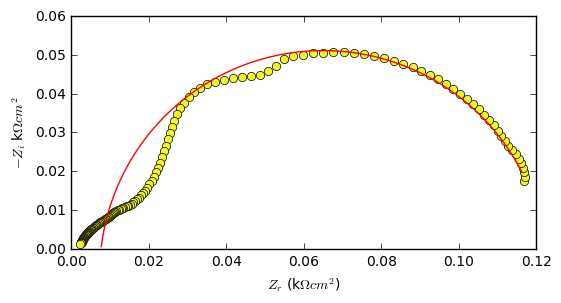

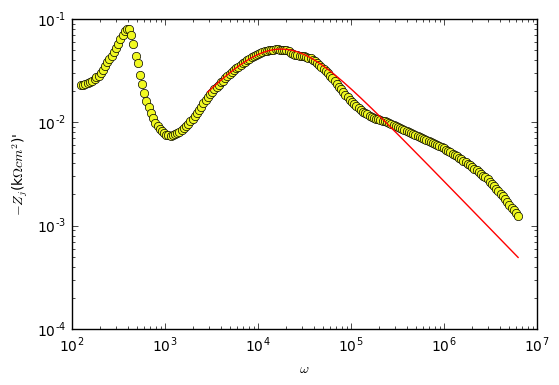

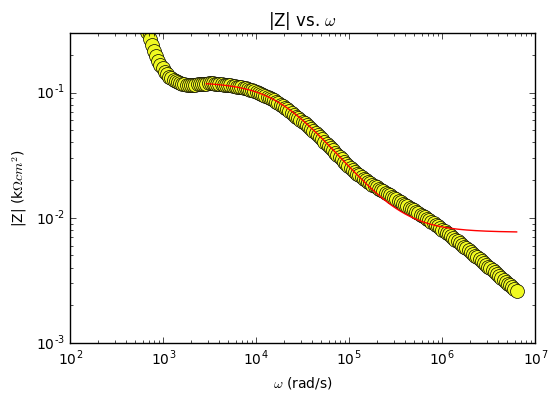

In [149]:
# define the Randles circuit
# def Za(w,z0,td,alpha):
#     return z0*(np.tanh((1j*w*td)**(alpha/2))/((1j*w*td)**(alpha/2)))

def randlesZ_finite_anom(w,Rct,Q,alpha,z0,td):
    return (Rct +  Za(w,z0,td,alpha) ) / (1 + ((1j*w)**alpha)*Q*(Rct + Za(w,z0,td,alpha)))

def seriesR(w,c):
    return c

# now define a new aggregate model
randles_anom = Model(randlesZ_finite_anom, prefix = 'r_')
arc1 = Model(arc,prefix = 'a1_')
# Rs = ConstantModel(independent_vars = 'w', prefix = 'Rs_')
# Rs = ConstantModel(x = ['w'], prefix = 'Rs_')
Rs = Model(seriesR,prefix = 'Rs_')

aggModel12 = Rs + randles_anom
# aggModel12 = Rs + arc1


# add parameters with guesses
params12 = lmf.Parameters()  

params12.add('Rs_c',value =  0.003, min = 0, max = 5)

# params12.add('a1_Rct',value = guessRct1, min = 0, max = 5)
# params12.add('a1_Q',value = guessQ1, min = 0, max = 1e-3)
# params12.add('a1_alpha',value = alphaG1, min = 0, max = 1)

params12.add('r_Rct',value = guessRct2, min = 0, max = 5)
params12.add('r_z0',value = .0001, min = 0, max = 1)
params12.add('r_td',value = 1e-4, min = 0, max = 1e-3)
params12.add('r_Q',value = guessQ2, min = 0, max = 1e-3)
params12.add('r_alpha',value = alphaG2, min = 0, max = 1)


# print(lmf.Parameters)

# make the data complex
data = Zr400(Tt)[bounds1[Tt-offSet]:]+1j*Zi400(Tt)[bounds1[Tt-offSet]:]

#try the fit
fit_result = aggModel12.fit(data, w = w(Tt)[bounds1[Tt-offSet]:],params = params12)

print(fit_result.fit_report())


fitMag = np.sqrt((np.imag(fit_result.best_fit))**2 + (np.real(fit_result.best_fit))**2)
reFit = np.real(fit_result.best_fit)
imFit = np.imag(fit_result.best_fit)

fig,ax = plt.subplots(1,1)
ax.plot(Zr400(Tt)[bounds1[Tt-offSet]:],-Zi400(Tt)[bounds1[Tt-offSet]:],'o', color = tuple(colSet[Tt]))
ax.plot(np.real(fit_result.best_fit),-np.imag(fit_result.best_fit),color = 'r')
ax.set_xlabel("$Z_{r}$ (k$\Omega cm^{2}$)")
ax.set_ylabel("$-Z_{i}$ k$\Omega cm^{2}$")
# ax.axis([0,.12, 0,.12])
ax.set_aspect('equal')

fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),abs(-Zi400(Tt)),'o', color = tuple(colSet[Tt]))
ax.plot(w(Tt)[bounds1[Tt-offSet]:],abs(imFit),color = 'r')
ax.set_xlabel("$\omega$")
ax.set_ylabel("$-Z_{j}$(k$\Omega cm^{2}$)'")
ax.set_xscale("log") 
ax.set_yscale("log") 


# |Z| vs. \omega
fig, ax = plt.subplots(1,1)
ax.plot(w(Tt),Zmag400(Tt),'o',c = tuple(colSet[Tt]), markersize = 10) 
ax.plot(w(Tt)[bounds1[Tt-offSet]:],fitMag, color = 'r')
ax.set_xlabel("$\omega$ (rad/s)")
ax.set_ylabel("|Z| (k$\Omega cm^{2}$)")
ax.set_xscale("log") 
ax.set_yscale("log") 
ax.set_title("|Z| vs. $\omega$")
ax.set_ylim([1e-3,3e-1]);
# ax.set_ylim([1e-3,1e2]);
# figName = '\\magZ_400mV_all.png'
# plt.savefig(figDir + figName,dpi = 300)
